In [1]:
from datetime import datetime
from sim.pool import AMMPoolHistory, CPMM, AMMWithBaulking, OraclePool
import matplotlib.pyplot as plt

import pandas as pd
import polars as pl

# These commands enlarge the column size of the dataframe so things like 0x... are not truncated
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

# Data Analysis of Prices

### Polars Preprocessing

In [2]:
# load parquet file into polars dataframe polars dataframe
cow_uni_chain_outer_pl = pl.read_parquet('data/cow_uni_chain_outer_pl_historical.parquet')

In [3]:
cow_uni_chain_outer_pl.shape

(527322, 23)

In [4]:
cow_uni_chain_outer_pl.select([
    (pl.col("swaps_tokenOut_id")).value_counts(),
    (pl.col("trades_buyToken_id")).value_counts(),
]).rows()

[({'swaps_tokenOut_id': 'USDC', 'counts': 191503},
  {'trades_buyToken_id': 'USDC', 'counts': 34524}),
 ({'swaps_tokenOut_id': 'WETH', 'counts': 177275},
  {'trades_buyToken_id': None, 'counts': 477198}),
 ({'swaps_tokenOut_id': None, 'counts': 158544},
  {'trades_buyToken_id': 'WETH', 'counts': 15600})]

In [5]:
# return the larger value between trades_buy_sell_ratio and trades_sell_buy_ratio in a lambda function. This serves as a column equalization function for trades_buy_sell_ratio and trades_sell_buy_ratio
execution_prices_pl = cow_uni_chain_outer_pl.with_columns([
    (pl.col("trades_buy_sell_ratio").apply(lambda x: x if x > 1 else 1/x)).alias('trades_buy_sell_ratio'),
    (pl.col("trades_sell_buy_ratio").apply(lambda x: x if x > 1 else 1/x)).alias('trades_sell_buy_ratio'),
    (pl.col("swaps_amountIn_amountOut_ratio").apply(lambda x: x if x > 1 else 1/x)).alias('swaps_amountIn_amountOut_ratio'),
    (pl.col("swaps_amountOut_amountIn_ratio").apply(lambda x: x if x > 1 else 1/x)).alias('swaps_amountOut_amountIn_ratio'),
])

In [6]:
# Add trade directionality flag.
# we label the trade direction WETH -> USDC when WETH is in the CoW buy column and the UniV3 amountOut column. 
# Conversely, the USDC -> WETH direction is when USDC is in the CoW sell column and the Univ3 amountIn column.
execution_prices_pl = execution_prices_pl.with_columns([
    (pl.col("trades_buyToken_id").apply(lambda x: True if x == 'WETH' else False)).alias('trades_buy_WETH'),
    (pl.col("swaps_tokenOut_id").apply(lambda x: True if x == 'WETH' else False)).alias('swaps_buy_WETH'),
])

In [7]:
# match cow trades with univ3 swaps
execution_prices_pl = execution_prices_pl.with_columns([
    (pl.col("trades_buy_WETH") & pl.col("swaps_buy_WETH")).alias('buy_buy_WETH'), # cow buy/uni buy WETH
    (~pl.col("trades_buy_WETH") & ~pl.col("swaps_buy_WETH")).alias('sell_sell_WETH'), # cow sell/uni sell WETH
    (pl.col("trades_buy_WETH") & ~pl.col("swaps_buy_WETH")).alias('buy_sell_WETH'), # cow buy/uni sel WETH
    (~pl.col("trades_buy_WETH") & pl.col("swaps_buy_WETH")).alias('sell_buy_WETH'), # cow sell/uni buy WETH
])

### Pandas Preprocessing & Charts

In [8]:
# convert execution_prices_pl to pandas dataframe for easier plotting.
execution_prices_pd = execution_prices_pl.to_pandas()

# set trades_timestamp as index and order by trades_timestamp
execution_prices_pd = execution_prices_pd.set_index('trades_timestamp').sort_index()

# create a new dataframe with a unique integer index. make the current timestamp index a column
reindexed_df = execution_prices_pd.reset_index()

In [9]:
reindexed_price_df = reindexed_df[[
    'trades_timestamp',                     # timestamp
    'trades_sell_buy_ratio',                # cow price
    'swaps_amountOut_amountIn_ratio',       # univ3 price
    'prices_price',                         # chain price
    'transaction_gas_fee_one_hop',          # univ3 single hop swap
    'transaction_gas_fee_median',           # univ3 median swap transaction cost
    'buy_buy_WETH',                          # cow/uni buy direction
    'sell_sell_WETH',                       # cow/uni sell direction
    'buy_sell_WETH',                        # cow buy/uni sell direction
    'sell_buy_WETH'                         # cow sell/uni buy direction
    ]]

# rename columns
reindexed_price_df.columns = [
    'timestamp',                            # timestamp
    'cow_price',                            # cow price
    'univ3_price',                          # univ3 price
    'chain_price',                          # chain price
    'transaction_gas_fee_one_hop',          # univ3 single hop swap
    'transaction_gas_fee_median',           # univ3 median swap transaction cost
    'buy_buy_WETH',                          # trade direction
    'sell_sell_WETH',                       # trade direction
    'buy_sell_WETH',                        # trade direction
    'sell_buy_WETH'                         # trade direction
]

In [10]:
# forward fill reindexed_price_df
reindexed_price_df = reindexed_price_df.fillna(method='ffill')

In [11]:
reindexed_price_df.shape

(527322, 10)

In [12]:
# convert transaction_gas_fee into usd amount
reindexed_price_df['transaction_gas_fee_one_hop_usd'] = reindexed_price_df['transaction_gas_fee_one_hop'] * reindexed_price_df['univ3_price']
reindexed_price_df['transaction_gas_fee_median_usd'] = reindexed_price_df['transaction_gas_fee_median'] * reindexed_price_df['univ3_price']

In [13]:
# filter trade directions
buy_buy_WETH_reindex_df = reindexed_price_df[reindexed_price_df['buy_buy_WETH'] == True]
sell_sell_WETH_reindex_df = reindexed_price_df[reindexed_price_df['sell_sell_WETH'] == True]
buy_sell_WETH_reindex_df = reindexed_price_df[reindexed_price_df['buy_sell_WETH'] == True]
sell_buy_WETH_reindex_df = reindexed_price_df[reindexed_price_df['sell_buy_WETH'] == True]

In [14]:
# print f the df shapes
print(buy_buy_WETH_reindex_df.shape)
print(sell_sell_WETH_reindex_df.shape)
print(buy_sell_WETH_reindex_df.shape)
print(sell_buy_WETH_reindex_df.shape)

(3362, 12)
(9023, 12)
(2459, 12)
(4740, 12)


In [15]:
# get all values below the 90th percentile
buy_buy_WETH_df = buy_buy_WETH_reindex_df[buy_buy_WETH_reindex_df['transaction_gas_fee_one_hop_usd'] < buy_buy_WETH_reindex_df['transaction_gas_fee_one_hop_usd'].quantile(0.90)]
sell_sell_WETH_df = sell_sell_WETH_reindex_df[sell_sell_WETH_reindex_df['transaction_gas_fee_one_hop_usd'] < sell_sell_WETH_reindex_df['transaction_gas_fee_one_hop_usd'].quantile(0.90)]
buy_sell_WETH_df = buy_sell_WETH_reindex_df[buy_sell_WETH_reindex_df['transaction_gas_fee_one_hop_usd'] < buy_sell_WETH_reindex_df['transaction_gas_fee_one_hop_usd'].quantile(0.90)]
sell_buy_WETH_df = sell_buy_WETH_reindex_df[sell_buy_WETH_reindex_df['transaction_gas_fee_one_hop_usd'] < sell_buy_WETH_reindex_df['transaction_gas_fee_one_hop_usd'].quantile(0.90)]

In [16]:
print(f'cow and uni buy count: {buy_buy_WETH_df.shape}')
print(f'cow and uni sell count: {sell_sell_WETH_df.shape}')
print(f'cow buy and uni sell count: {buy_sell_WETH_df.shape}')
print(f'uni sell and cow buy count: {sell_buy_WETH_df.shape}')

cow and uni buy count: (3025, 12)
cow and uni sell count: (8120, 12)
cow buy and uni sell count: (2213, 12)
uni sell and cow buy count: (4263, 12)


In [17]:
# single hop gas adjusted prices
buy_buy_WETH_df.loc[:, 'univ3_gas_single_hop_price'] = buy_buy_WETH_df.loc[:, 'univ3_price'] + buy_buy_WETH_df.loc[:, 'transaction_gas_fee_one_hop_usd']
sell_sell_WETH_df.loc[:, 'univ3_gas_single_hop_price'] = sell_sell_WETH_df.loc[:, 'univ3_price'] - sell_sell_WETH_df.loc[:, 'transaction_gas_fee_one_hop_usd']
buy_sell_WETH_df.loc[:, 'univ3_gas_single_hop_price'] = buy_sell_WETH_df.loc[:, 'univ3_price'] - buy_sell_WETH_df.loc[:, 'transaction_gas_fee_one_hop_usd']
sell_buy_WETH_df.loc[:, 'univ3_gas_single_hop_price'] = sell_buy_WETH_df.loc[:, 'univ3_price'] + sell_buy_WETH_df.loc[:, 'transaction_gas_fee_one_hop_usd']

# add new price values that add the gas cost
buy_buy_WETH_df.loc[:, 'univ3_gas_median_price'] = buy_buy_WETH_df.loc[:, 'univ3_price'] + buy_buy_WETH_df.loc[:, 'transaction_gas_fee_median_usd']
sell_sell_WETH_df.loc[:, 'univ3_gas_median_price'] = sell_sell_WETH_df.loc[:, 'univ3_price'] - sell_sell_WETH_df.loc[:, 'transaction_gas_fee_median_usd']
buy_sell_WETH_df.loc[:, 'univ3_gas_median_price'] = buy_sell_WETH_df.loc[:, 'univ3_price'] - buy_sell_WETH_df.loc[:, 'transaction_gas_fee_median_usd']
sell_buy_WETH_df.loc[:, 'univ3_gas_median_price'] = sell_buy_WETH_df.loc[:, 'univ3_price'] + sell_buy_WETH_df.loc[:, 'transaction_gas_fee_median_usd']

/tmp/ipykernel_24708/807861930.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buy_buy_WETH_df.loc[:, 'univ3_gas_single_hop_price'] = buy_buy_WETH_df.loc[:, 'univ3_price'] + buy_buy_WETH_df.loc[:, 'transaction_gas_fee_one_hop_usd']
/tmp/ipykernel_24708/807861930.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sell_sell_WETH_df.loc[:, 'univ3_gas_single_hop_price'] = sell_sell_WETH_df.loc[:, 'univ3_price'] - sell_sell_WETH_df.loc[:, 'transaction_gas_fee_one_hop_usd']
/tmp/ipykernel_24708/807861930.py:

In [18]:
# convert index to datetime format
sell_sell_WETH_df.loc[:, 'timestamp'] = pd.to_datetime(sell_sell_WETH_df.timestamp, utc=True, unit='s')
buy_buy_WETH_df.loc[:, 'timestamp'] = pd.to_datetime(buy_buy_WETH_df.timestamp, utc=True, unit='s')
buy_sell_WETH_df.loc[:, 'timestamp'] = pd.to_datetime(buy_sell_WETH_df.timestamp, utc=True, unit='s')
sell_buy_WETH_df.loc[:, 'timestamp'] = pd.to_datetime(sell_buy_WETH_df.timestamp, utc=True, unit='s')

/tmp/ipykernel_24708/530421318.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sell_sell_WETH_df.loc[:, 'timestamp'] = pd.to_datetime(sell_sell_WETH_df.timestamp, utc=True, unit='s')
/tmp/ipykernel_24708/530421318.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buy_buy_WETH_df.loc[:, 'timestamp'] = pd.to_datetime(buy_buy_WETH_df.timestamp, utc=True, unit='s')
/tmp/ipykernel_24708/530421318.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

In [19]:
# define color scheme
cow_color = '#0000b3'
univ3_color = '#993366'
chain_color = '#004d00'

In [20]:
# what is the date at the -2000th row for sell_sell_WETH_df?
print(sell_sell_WETH_df.iloc[-2000].timestamp)

graph_chart_date = sell_sell_WETH_df.iloc[-2000].timestamp

2022-10-08 20:19:35+00:00


In [21]:
# first date in the dataframe
print(sell_sell_WETH_df.iloc[0].timestamp)

graph_chart_date = sell_sell_WETH_df.iloc[0].timestamp

2021-08-06 13:27:54+00:00


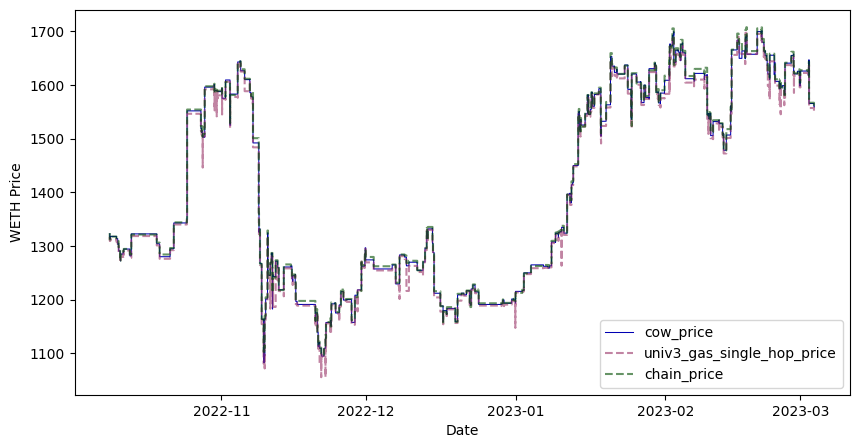

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [22]:
# plot prices on y axis and timestamp on x axis
fig1, ax = plt.subplots(figsize=(10, 5))
ax.step(
    sell_sell_WETH_df['timestamp'].iloc[-2000:], 
    sell_sell_WETH_df['cow_price'].iloc[-2000:], 
    label='cow_price',color=cow_color, linewidth=.75)
ax.step(
    sell_sell_WETH_df['timestamp'].iloc[-2000:], 
    sell_sell_WETH_df['univ3_gas_single_hop_price'].iloc[-2000:], '--',
    label='univ3_gas_single_hop_price', color=univ3_color, alpha=.6)
ax.step(
    sell_sell_WETH_df['timestamp'].iloc[-2000:], 
    sell_sell_WETH_df['chain_price'].iloc[-2000:], '--',
    label='chain_price', color=chain_color, alpha=.6)

plt.xlabel('Date')
plt.ylabel('WETH Price')
plt.legend()
plt.show();

# save figure
fig1.savefig('../report/diagrams/weth_sell_line.eps', format='eps', bbox_inches='tight')
fig1.savefig('../report/diagrams/weth_sell_line.pdf', format='pdf', bbox_inches='tight')

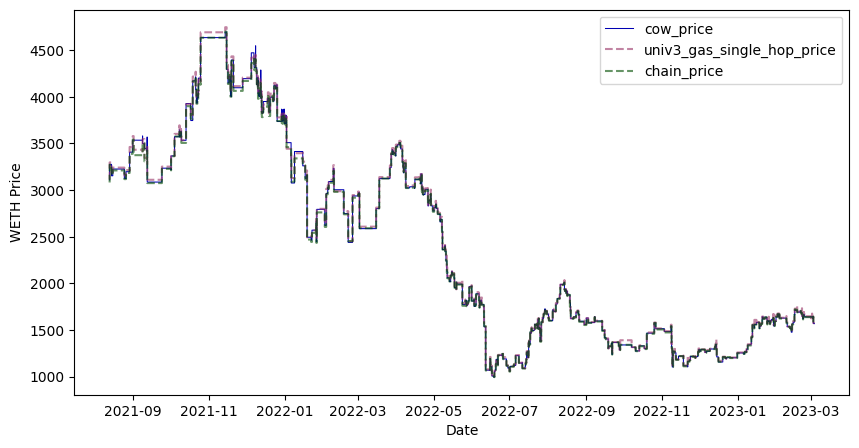

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [23]:
# plot buy_buy_WETH_df chart where the timestamp is after the graph_chart_date variable
fig2, ax = plt.subplots(figsize=(10, 5))
ax.step(
    buy_buy_WETH_df[buy_buy_WETH_df['timestamp'] > graph_chart_date]['timestamp'],
    buy_buy_WETH_df[buy_buy_WETH_df['timestamp'] > graph_chart_date]['cow_price'],
    label='cow_price',color=cow_color, linewidth=.75)
ax.step(
    buy_buy_WETH_df[buy_buy_WETH_df['timestamp'] > graph_chart_date]['timestamp'],
    buy_buy_WETH_df[buy_buy_WETH_df['timestamp'] > graph_chart_date]['univ3_gas_single_hop_price'], '--',
    label='univ3_gas_single_hop_price', color=univ3_color, alpha=.6)
ax.step(
    buy_buy_WETH_df[buy_buy_WETH_df['timestamp'] > graph_chart_date]['timestamp'],
    buy_buy_WETH_df[buy_buy_WETH_df['timestamp'] > graph_chart_date]['chain_price'], '--',
    label='chain_price', color=chain_color, alpha=.6)

plt.xlabel('Date')
plt.ylabel('WETH Price')
plt.legend()
plt.show();

fig2.savefig('../report/diagrams/weth_buy_line.eps', format='eps', bbox_inches='tight')
fig2.savefig('../report/diagrams/weth_buy_line.pdf', format='pdf', bbox_inches='tight')

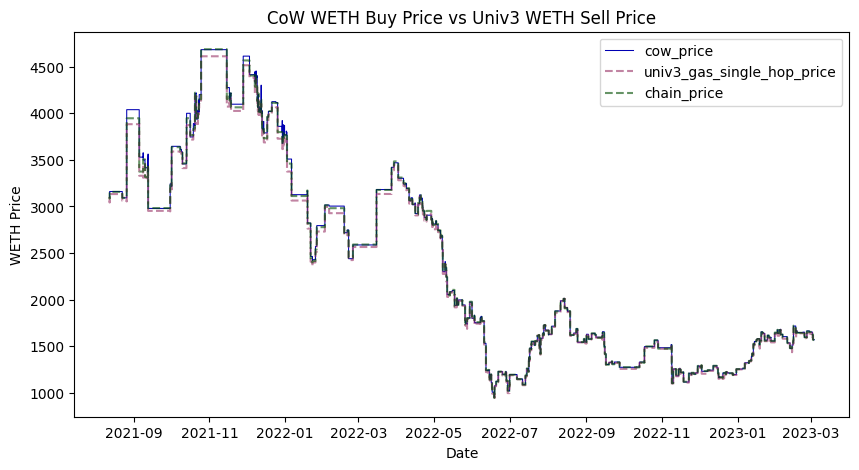

In [24]:
# plot prices on y axis and timestamp on x axis
fig3, ax = plt.subplots(figsize=(10, 5))
ax.step(
    buy_sell_WETH_df[buy_sell_WETH_df['timestamp'] > graph_chart_date]['timestamp'],
    buy_sell_WETH_df[buy_sell_WETH_df['timestamp'] > graph_chart_date]['cow_price'],
    label='cow_price',color=cow_color, linewidth=.75)
ax.step(
    buy_sell_WETH_df[buy_sell_WETH_df['timestamp'] > graph_chart_date]['timestamp'],
    buy_sell_WETH_df[buy_sell_WETH_df['timestamp'] > graph_chart_date]['univ3_gas_single_hop_price'], '--',
    label='univ3_gas_single_hop_price', color=univ3_color, alpha=.6)
ax.step(
    buy_sell_WETH_df[buy_sell_WETH_df['timestamp'] > graph_chart_date]['timestamp'],
    buy_sell_WETH_df[buy_sell_WETH_df['timestamp'] > graph_chart_date]['chain_price'], '--',
    label='chain_price', color=chain_color, alpha=.6)

plt.xlabel('Date')
plt.ylabel('WETH Price')
plt.legend()
plt.title('CoW WETH Buy Price vs Univ3 WETH Sell Price')
plt.show();

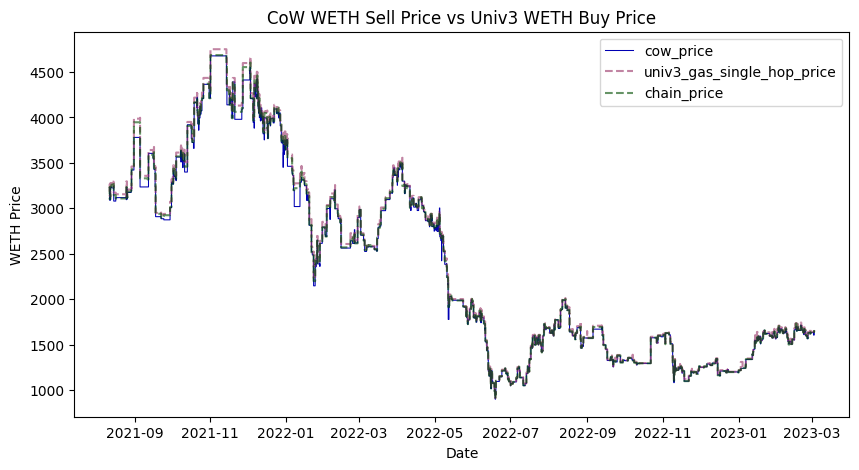

In [25]:
# plot prices on y axis and timestamp on x axis
fig4, ax = plt.subplots(figsize=(10, 5))
ax.step(
    sell_buy_WETH_df[sell_buy_WETH_df['timestamp'] > graph_chart_date]['timestamp'],
    sell_buy_WETH_df[sell_buy_WETH_df['timestamp'] > graph_chart_date]['cow_price'],
    label='cow_price',color=cow_color, linewidth=.75)
ax.step(
    sell_buy_WETH_df[sell_buy_WETH_df['timestamp'] > graph_chart_date]['timestamp'],
    sell_buy_WETH_df[sell_buy_WETH_df['timestamp'] > graph_chart_date]['univ3_gas_single_hop_price'], '--',
    label='univ3_gas_single_hop_price', color=univ3_color, alpha=.6)
ax.step(
    sell_buy_WETH_df[sell_buy_WETH_df['timestamp'] > graph_chart_date]['timestamp'],
    sell_buy_WETH_df[sell_buy_WETH_df['timestamp'] > graph_chart_date]['chain_price'], '--',
    label='chain_price', color=chain_color, alpha=.6)

plt.xlabel('Date')
plt.ylabel('WETH Price')
plt.legend()
plt.title('CoW WETH Sell Price vs Univ3 WETH Buy Price')
plt.show();

### Price Differences Charts

In [26]:
# get the price price difference percent between cow and univ3 gas adjusted price in buy_buy_WETH_df
buy_buy_WETH_df['cow_univ3_gas_adj_price_diff_percent_single'] = (buy_buy_WETH_df['cow_price'] - buy_buy_WETH_df['univ3_gas_single_hop_price']) / buy_buy_WETH_df['cow_price'] * 100
buy_buy_WETH_df['cow_univ3_gas_adj_price_diff_percent_median'] = (buy_buy_WETH_df['cow_price'] - buy_buy_WETH_df['univ3_gas_median_price']) / buy_buy_WETH_df['cow_price'] * 100

/tmp/ipykernel_24708/2877689058.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buy_buy_WETH_df['cow_univ3_gas_adj_price_diff_percent_single'] = (buy_buy_WETH_df['cow_price'] - buy_buy_WETH_df['univ3_gas_single_hop_price']) / buy_buy_WETH_df['cow_price'] * 100
/tmp/ipykernel_24708/2877689058.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buy_buy_WETH_df['cow_univ3_gas_adj_price_diff_percent_median'] = (buy_buy_WETH_df['cow_price'] - buy_buy_WETH_df['univ3_gas_median_price']) / buy_buy_WETH_df['cow_

In [27]:
# get the price price difference percent between cow and univ3 gas adjusted price in sell_sell_WETH_df
sell_sell_WETH_df['cow_univ3_gas_adj_price_diff_percent_single'] = (sell_sell_WETH_df['cow_price'] - sell_sell_WETH_df['univ3_gas_single_hop_price']) / sell_sell_WETH_df['cow_price'] * 100
sell_sell_WETH_df['cow_univ3_gas_adj_price_diff_percent_median'] = (sell_sell_WETH_df['cow_price'] - sell_sell_WETH_df['univ3_gas_median_price']) / sell_sell_WETH_df['cow_price'] * 100

/tmp/ipykernel_24708/269593933.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sell_sell_WETH_df['cow_univ3_gas_adj_price_diff_percent_single'] = (sell_sell_WETH_df['cow_price'] - sell_sell_WETH_df['univ3_gas_single_hop_price']) / sell_sell_WETH_df['cow_price'] * 100
/tmp/ipykernel_24708/269593933.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sell_sell_WETH_df['cow_univ3_gas_adj_price_diff_percent_median'] = (sell_sell_WETH_df['cow_price'] - sell_sell_WETH_df['univ3_gas_median_price']) / sell_sell

In [28]:
# calculate mean deviation between cow and chain prices for each row
sell_sell_WETH_df['cow_chain_price_diff_percent'] = (sell_sell_WETH_df['chain_price'] - sell_sell_WETH_df['cow_price']) / sell_sell_WETH_df['cow_price'] * 100
buy_buy_WETH_df['cow_chain_price_diff_percent'] = (buy_buy_WETH_df['chain_price'] - buy_buy_WETH_df['cow_price']) / buy_buy_WETH_df['cow_price'] * 100

/tmp/ipykernel_24708/3633560276.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sell_sell_WETH_df['cow_chain_price_diff_percent'] = (sell_sell_WETH_df['chain_price'] - sell_sell_WETH_df['cow_price']) / sell_sell_WETH_df['cow_price'] * 100
/tmp/ipykernel_24708/3633560276.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buy_buy_WETH_df['cow_chain_price_diff_percent'] = (buy_buy_WETH_df['chain_price'] - buy_buy_WETH_df['cow_price']) / buy_buy_WETH_df['cow_price'] * 100


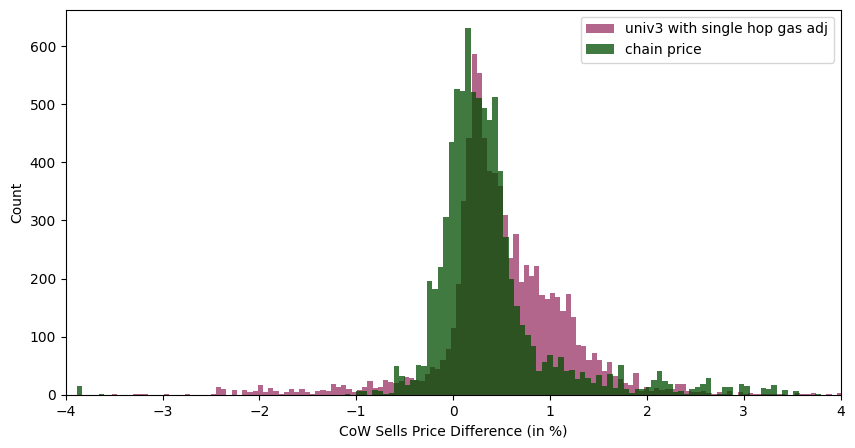

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [29]:
# plot histogram of the price diffs
# https://matplotlib.org/stable/gallery/misc/rasterization_demo.html
fig3, ax = plt.subplots(figsize=(10, 5))
ax.hist(
    sell_sell_WETH_df['cow_univ3_gas_adj_price_diff_percent_single'],
    bins=250,
    label='univ3 with single hop gas adj',
    color=univ3_color,
    alpha=0.75)
ax.hist(
    sell_sell_WETH_df['cow_chain_price_diff_percent'],
    bins=250,
    label='chain price',
    color=chain_color,
    alpha=0.75)

ax.set_xlim(-4, 4)
plt.xlabel('CoW Sells Price Difference (in %)')
plt.ylabel('Count')
plt.legend()
plt.show();

#save as eps
fig3.savefig('../report/diagrams/weth_sell_hist.eps', format='eps', bbox_inches='tight')
fig3.savefig('../report/diagrams/weth_sell_hist.pdf', format='pdf', bbox_inches='tight')

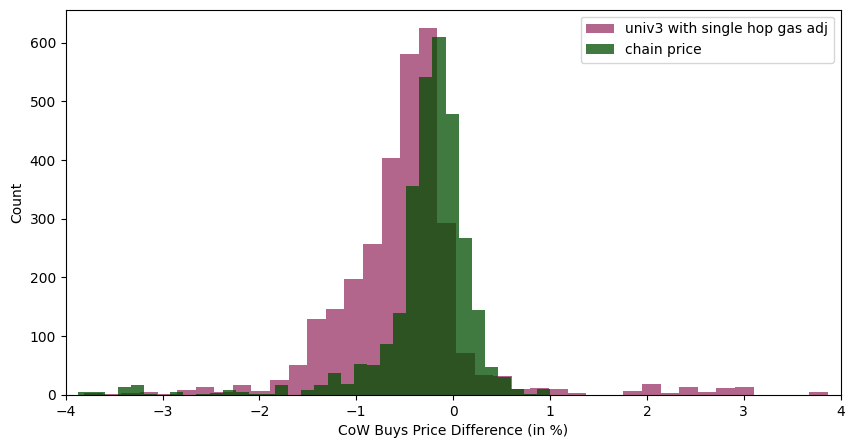

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [30]:
# plot histogram of the price diffs
fig3, ax = plt.subplots(figsize=(10, 5))
ax.hist(
    buy_buy_WETH_df['cow_univ3_gas_adj_price_diff_percent_single'],
    bins=50,
    label='univ3 with single hop gas adj',
    color=univ3_color,
    alpha=0.75)
ax.hist(
    buy_buy_WETH_df['cow_chain_price_diff_percent'],
    bins=50,
    label='chain price',
    color=chain_color,
    alpha=0.75)

ax.set_xlim(-4, 4)
plt.xlabel('CoW Buys Price Difference (in %)')
plt.ylabel('Count')
plt.legend()
plt.show();

#save as eps
fig3.savefig('../report/diagrams/weth_buy_hist.eps', format='eps', bbox_inches='tight')
fig3.savefig('../report/diagrams/weth_buy_hist.pdf', format='pdf', bbox_inches='tight')

In [31]:
# print the mean deviation of cow price from chainlink price with f strings
print(f"Mean deviation of cow sell price from chainlink price (90th percentile): {sell_sell_WETH_df['cow_chain_price_diff_percent'].mean():.2f}%")
print(f"Mean deviation of cow buy price from chainlink price (90th percentile): {buy_buy_WETH_df['cow_chain_price_diff_percent'].mean():.2f}%")

Mean deviation of cow sell price from chainlink price (90th percentile): 0.40%
Mean deviation of cow buy price from chainlink price (90th percentile): -0.33%


In [32]:
# statistics for buy_WETH_df single hop price difference
buy_buy_WETH_df[['transaction_gas_fee_one_hop_usd', 'cow_univ3_gas_adj_price_diff_percent_median', 'cow_univ3_gas_adj_price_diff_percent_single', 'cow_chain_price_diff_percent']].describe()

,transaction_gas_fee_one_hop_usd,cow_univ3_gas_adj_price_diff_percent_median,cow_univ3_gas_adj_price_diff_percent_single,cow_chain_price_diff_percent
count,3025.000000,3025.000000,3025.000000,3025.000000
mean,18.025399,-1.455991,-0.490217,-0.331296
std,16.116630,1.275273,0.793871,0.727577
min,0.732861,-11.480409,-4.962007,-5.763109
25%,4.317270,-1.980871,-0.821843,-0.402209
50%,11.880526,-1.192105,-0.470148,-0.182791
75%,29.684810,-0.674274,-0.230811,-0.032257
max,58.706795,2.703885,4.636215,1.004717


In [33]:
sell_sell_WETH_df[['transaction_gas_fee_one_hop_usd', 'cow_univ3_gas_adj_price_diff_percent_median', 'cow_univ3_gas_adj_price_diff_percent_single', 'cow_chain_price_diff_percent']].describe()

,transaction_gas_fee_one_hop_usd,cow_univ3_gas_adj_price_diff_percent_median,cow_univ3_gas_adj_price_diff_percent_single,cow_chain_price_diff_percent
count,8120.000000,8120.000000,8120.000000,8120.000000
mean,19.518082,1.546445,0.509903,0.402038
std,17.340280,1.279758,0.730525,0.716555
min,0.410962,-4.704170,-8.210004,-3.885598
25%,4.564326,0.662618,0.207947,0.060359
50%,13.032172,1.217647,0.442521,0.264827
75%,32.078104,2.189988,0.862442,0.503743
max,62.298010,12.927627,5.252639,10.231478


### Simulations (WIP)

In [34]:
# divide the merged dataframe into smaller dataframes.
uni_swaps_df = cow_uni_chain_outer_pl[
    'trades_timestamp',  
    'swaps_tokenIn_id',
    'swaps_tokenOut_id',
    'swaps_amountIn_converted',
    'swaps_amountOut_converted'
    ].drop_nulls()

chain_df = cow_uni_chain_outer_pl[    
    'trades_timestamp', 
    'prices_assetPair_id', 
    'prices_price'].drop_nulls()


cow_df = cow_uni_chain_outer_pl[
    'trades_timestamp',
    'swaps_blockNumber',
    'trades_txHash',
    'trades_feeAmount',
    'trades_sellToken_id',
    'trades_buyToken_id',
    'trades_sellAmount_converted',
    'trades_buyAmount_converted',
    'name',
    'environment'
].drop_nulls()

In [35]:
# convert to pandas dataframes
uni_swaps_df = uni_swaps_df.to_pandas()
chain_df = chain_df.to_pandas()
cow_df = cow_df.to_pandas()

In [36]:
# sort all by trades timestamp
uni_swaps_df = uni_swaps_df.sort_values(by=['trades_timestamp'])
chain_df = chain_df.sort_values(by=['trades_timestamp'])
cow_df = cow_df.sort_values(by=['trades_timestamp'])

In [37]:
# filter based on timestamp
uni_swaps_df = uni_swaps_df[uni_swaps_df['trades_timestamp'] >= 1643673600]
chain_df = chain_df[chain_df['trades_timestamp'] >= 1643673600]
cow_df = cow_df[cow_df['trades_timestamp'] >= 1643673600]

In [38]:
# Find the first and last value in the timestamp column
first_timestamp_uni = uni_swaps_df['trades_timestamp'].min()
last_timestamp_uni = uni_swaps_df['trades_timestamp'].max()
print(f'uni first timestamp: {first_timestamp_uni} \nlast timestamp: {last_timestamp_uni}')

# Find the first and last value in the timestamp column
first_timestamp_chain = chain_df['trades_timestamp'].min()
last_timestamp_chain = chain_df['trades_timestamp'].max()
print(f'chain first timestamp: {first_timestamp_chain} \nlast timestamp: {last_timestamp_chain}')

uni first timestamp: 1643673948 
last timestamp: 1677890675
chain first timestamp: 1643676926 
last timestamp: 1677891335


In [39]:
timestamps = pd.DataFrame({'trades_timestamp': range(first_timestamp_uni, last_timestamp_uni + 1)})

In [40]:
print(len(timestamps))

34216728


#### Create External Market Oracle with Chainlink Price

In [41]:
# left merge chain_df with empty timestamps_df
chain_filled_df = pd.merge(timestamps, chain_df, on='trades_timestamp', how='left')
# Forward-fill missing values
chain_filled_df.fillna(method='ffill', inplace=True)
# sort by timestamp
chain_filled_df = chain_filled_df.sort_values('trades_timestamp', ascending=True)

In [42]:
# get first non null price row
first_non_null_price_row = chain_filled_df[chain_filled_df['prices_price'].notnull()].iloc[0]

In [43]:
# get simulation initialization data from the first row of the chain data
initialization_df_row = chain_filled_df[chain_filled_df["trades_timestamp"] == first_non_null_price_row['trades_timestamp']]
initilization_price = initialization_df_row['prices_price']

# initialize 100m USDC supply reserve amount
USDC_reserves_USD = 100000000

token0_start = int(USDC_reserves_USD/initilization_price)
print(f"Token 0 WETH initial reserves: \t{token0_start}")

token1_start = USDC_reserves_USD
print(f"Token 1 USDC initial reserves :\t{token1_start}")

# convert initialization_df['trades_timestamp'][0] to datetime object
datetime_object = datetime.fromtimestamp(initialization_df_row['trades_timestamp'].iloc[0]).strftime('%Y-%m-%d')

print(f'start date: {datetime_object}, start WETH price: {initilization_price.iloc[0]}')

Token 0 WETH initial reserves: 	37156
Token 1 USDC initial reserves :	100000000
start date: 2022-01-31, start WETH price: 2691.31586673


In [44]:
# convert into series. This data structure is required for the simulation class input
price_s = chain_filled_df.set_index("trades_timestamp")["prices_price"]

# drop null values
price_s = price_s[price_s.index > first_non_null_price_row['trades_timestamp']]

In [45]:
# merge duplicated index values in price_s. This is the 'external market oracle' for the CPMM
price_s = price_s.groupby(level=0).first()

#### Create External market price represented by CoW

In [46]:
# drop NaN values in cow_price column from the earlier completed dataset.
cow_oracle_df = reindexed_price_df[reindexed_price_df['cow_price'].notnull()]

In [47]:
# create an oracle dict which serves as a price oracle for OraclePool
oracle_dict = [{"ts": row["timestamp"], "p": row["cow_price"]} for _, row in cow_oracle_df.iterrows()]

### Oracle Prices

In [80]:
# convert oracle_dict to a df
oracle_df = pd.DataFrame(oracle_dict)

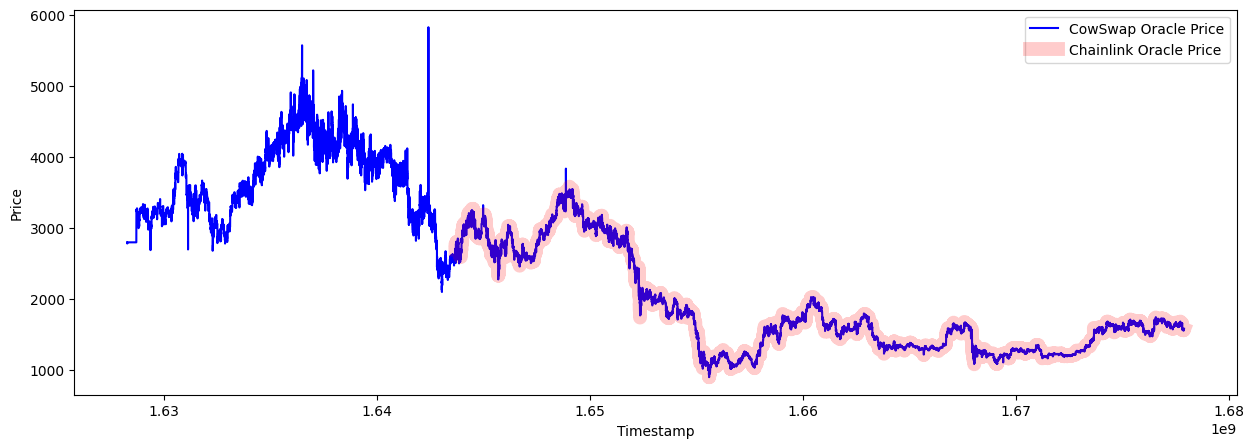

In [91]:
# plot oracle_df and price_s on same plot
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(oracle_df['ts'], oracle_df['p'], label='CowSwap Oracle Price', color='blue')
ax.plot(price_s.index, price_s, label='Chainlink Oracle Price', color='red', alpha=0.2, linewidth=10)
ax.set_xlabel('Timestamp')
ax.set_ylabel('Price')
ax.legend()
plt.show()

### Simulation Execution

In [48]:
# Create feedlot history objects, which store the data of the simulation.
feedlot1 = AMMPoolHistory(token0_start, token1_start)
feedlot2 = AMMPoolHistory(token0_start, token1_start)

In [49]:
# Instantiate the CPMM object with the AMMPool object
cpmm = CPMM(pool=feedlot1)
cpmm_SI_flow = AMMWithBaulking(cpmm, price_s)
oracle_pool = OraclePool(feedlot2, oracle_dict)

In [50]:
depleted_reserve_df = []

In [63]:
uni_swaps_df

,trades_timestamp,swaps_tokenIn_id,swaps_tokenOut_id,swaps_amountIn_converted,swaps_amountOut_converted
252246,1643673948,WETH,USDC,1.097383,2936.510663
252245,1643674049,USDC,WETH,457538.400000,169.817246
252244,1643674124,USDC,WETH,304930.800000,113.017931
252243,1643674146,USDC,WETH,762505.891677,281.845732
252242,1643674727,WETH,USDC,95.696253,257727.468211
...,...,...,...,...,...
255755,1677890579,USDC,WETH,31491.829132,20.000000
61554,1677890579,USDC,WETH,40822.415762,25.926294
61552,1677890663,USDC,WETH,7559.525687,4.799396
61553,1677890663,USDC,WETH,123271.274315,78.274518


In [51]:
depleted_reserve_count = 0

# Iterate through the rows of the dataframe
for index, row in uni_swaps_df.iterrows():
    # check if the timestamp of the trade is greater than the external market price oracle data
    if row['trades_timestamp'] > cpmm_SI_flow.target_prices.index[0]: 
        # check if tokenIn is WETH or USDC
        match row['swaps_tokenIn_id']:
            case 'WETH':
                token = 0
                amt = row['swaps_amountIn_converted']
            case 'USDC':
                token = 1
                amt = row['swaps_amountIn_converted']

        # If reserve is depleted, nullify the trade by setting amt in/out to 0.
        # Run the swap function on the AMM pool
        amta, amtb = cpmm_SI_flow.maybe_market_order_sell(amt,token,row['trades_timestamp'])

        amt0, amt1 = oracle_pool.market_order_sell(amt,token,row['trades_timestamp'])
        if amt0 == 0:
            # print(f"Reserves depleted at time {row['trades_timestamp']}.")
            # print(f"Pool reserves: ({feedlot1.reserves[0], feedlot1.reserves[1]})")
            depleted_reserve_count += 1
            depleted_reserve_df.append(row)
        # print(f"Traded {amt0} for {amt1}\tat time {row['trades_timestamp']}.")
        # print(f"Pool reserves: ({feedlot1.reserves[0], feedlot1.reserves[1]})")

In [52]:
print(f'depleted_reserve_count: {depleted_reserve_count}, total swaps going through sim: {uni_swaps_df.size}')

depleted_reserve_count: 9509, total swaps going through sim: 1293075


In [53]:
depleted_reserve_df

[trades_timestamp              1643678488
 swaps_tokenIn_id                    USDC
 swaps_tokenOut_id                   WETH
 swaps_amountIn_converted     1149.231361
 swaps_amountOut_converted       0.425028
 Name: 255306, dtype: object,
 trades_timestamp              1643680105
 swaps_tokenIn_id                    USDC
 swaps_tokenOut_id                   WETH
 swaps_amountIn_converted     1343.813577
 swaps_amountOut_converted            0.5
 Name: 60946, dtype: object,
 trades_timestamp              1643680228
 swaps_tokenIn_id                    USDC
 swaps_tokenOut_id                   WETH
 swaps_amountIn_converted     1454.566719
 swaps_amountOut_converted       0.541101
 Name: 60944, dtype: object,
 trades_timestamp             1643689269
 swaps_tokenIn_id                   USDC
 swaps_tokenOut_id                  WETH
 swaps_amountIn_converted         2500.0
 swaps_amountOut_converted      0.909511
 Name: 74488, dtype: object,
 trades_timestamp              1643696255
 swaps

In [54]:
results1_df = pd.DataFrame(feedlot1.history)
results2_df = pd.DataFrame(feedlot2.history)

In [55]:
# merge results1_df with chain_df on timestamp
results1_merged_df = pd.merge(results1_df, chain_df, left_on='ts', right_on='trades_timestamp', how='left')
# calculate usd value of reserve0, which is the WETH reserves
results1_merged_df['reserve0_usd'] = results1_merged_df['reserve0'] * results1_merged_df['prices_price']
# calculate tvl
results1_merged_df['tvl'] = results1_merged_df['reserve0_usd'] + results1_merged_df['reserve1']

In [56]:
# merge results1_df with chain_df on timestamp
results2_merged_df = pd.merge(results2_df, chain_df, left_on='ts', right_on='trades_timestamp', how='left')
# calculate usd value of reserve0, which is the WETH reserves
results2_merged_df['reserve0_usd'] = results2_merged_df['reserve0'] * results2_merged_df['prices_price']
# calculate tvl
results2_merged_df['tvl'] = results2_merged_df['reserve0_usd'] + results2_merged_df['reserve1']

In [57]:
# calculate tvl
results1_merged_df['tvl'] = results1_merged_df['reserve0_usd'] + results1_merged_df['reserve1']
results2_merged_df['tvl'] = results2_merged_df['reserve0_usd'] + results2_merged_df['reserve1']

In [58]:
uni_swaps_df.size

1293075

In [59]:
# count the number of swaps in results1 and results 2
print(f"Number of swaps in the order flow historical data: {uni_swaps_df.size}")
print(f"Number of swaps accepted in CPMM: {results1_merged_df.size}")
print(f"Number of swaps accepted in OraclePool: {results2_merged_df.size}")

Number of swaps in the order flow historical data: 1293075
Number of swaps accepted in CPMM: 2871712
Number of swaps accepted in OraclePool: 2176488


In [60]:
# drop first row
results1_merged_df = results1_merged_df.iloc[1:]
results2_merged_df = results2_merged_df.iloc[1:]

In [61]:
# convert timestamp to datetime
results1_merged_df['ts'] = pd.to_datetime(results1_merged_df['ts'], unit='s')
results2_merged_df['ts'] = pd.to_datetime(results2_merged_df['ts'], unit='s')

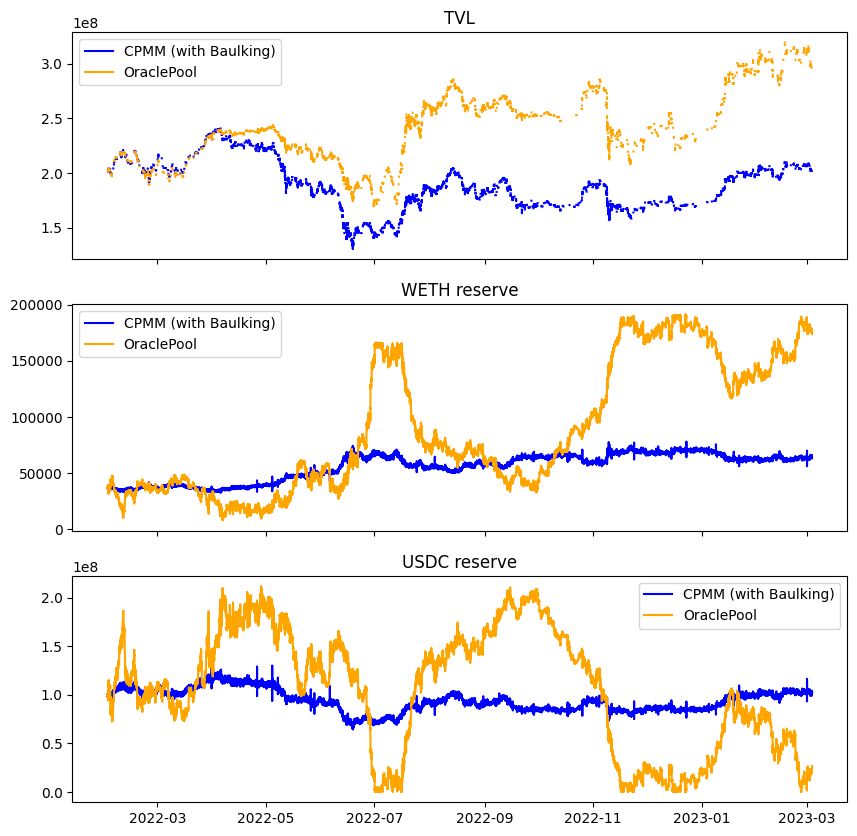

In [74]:
# plot subplots of merged dfs tvl
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
ax0.plot(results1_merged_df['ts'], results1_merged_df['tvl'], color='blue', label='CPMM (with Baulking)')
ax0.plot(results2_merged_df['ts'], results2_merged_df['tvl'], color='orange', label='OraclePool')
ax0.set_title('TVL')
ax0.legend()
ax1.plot(results1_merged_df['ts'], results1_merged_df['reserve0'], color='blue', label='CPMM (with Baulking)')
ax1.plot(results2_merged_df['ts'], results2_merged_df['reserve0'], color='orange', label='OraclePool')
ax1.set_title('WETH reserve')
ax1.legend()
ax2.plot(results1_merged_df['ts'], results1_merged_df['reserve1'], color='blue', label='CPMM (with Baulking)')
ax2.plot(results2_merged_df['ts'], results2_merged_df['reserve1'], color='orange', label='OraclePool')
ax2.set_title('USDC reserve')
ax2.legend()
plt.show();

In [64]:
#calculate reserve0 delta
results1_merged_df['reserve0_delta'] = results1_merged_df['reserve0'].diff()

<AxesSubplot:>

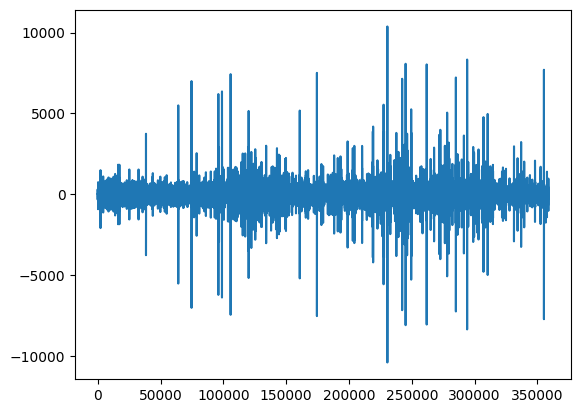

In [65]:
results1_merged_df['reserve0_delta'].plot()

In [73]:
# get largest uni_swaps_df buy orders where swaps_tokenIn_id is WETH
uni_swaps_df[uni_swaps_df['swaps_tokenIn_id'] == 'WETH'].nlargest(10, 'swaps_amountIn_converted')

,trades_timestamp,swaps_tokenIn_id,swaps_tokenOut_id,swaps_amountIn_converted,swaps_amountOut_converted
35007,1666732823,WETH,USDC,10371.997351,1.525652e+07
135708,1673219519,WETH,USDC,8330.432460,1.080993e+07
194749,1668013799,WETH,USDC,8069.398727,9.720373e+06
71147,1669246259,WETH,USDC,8030.174097,9.708165e+06
83560,1677642563,WETH,USDC,7700.000000,1.247148e+07
104723,1659568138,WETH,USDC,7508.114757,1.191068e+07
148246,1671785819,WETH,USDC,7223.066971,8.899709e+06
68310,1667933651,WETH,USDC,7143.297605,1.000076e+07
55422,1651672328,WETH,USDC,7000.000000,1.975644e+07
181894,1653718872,WETH,USDC,6361.731751,1.140045e+07
